In [ ]:
%load_ext autoreload
%matplotlib inline

In [ ]:
# always reload modules marked with "%aimport"
%autoreload 1

In [ ]:
#Load data

%store -r ili_data
%store -r delphi_data

In [ ]:
#sanity check
delphi_data.head()

In [635]:
nstates = len(delphi_data.location.unique())
print("Number of location : {}".format(nstates))

Number of location : 47


In [ ]:
ili_data.head()

In [634]:
select = ['date','state','year',
            'week_temp',
            'week_prcp',
            'latitude', 
            'longitude', 
            'month', 
            'week',
            'ili_activity_label',
            'ili_activity_group']
raw = ili_data[select].copy()
l = len(raw.columns)
print("The data contains {} features".format(l))
raw.head()

The data contains 11 features


,date,state,year,week_temp,week_prcp,latitude,longitude,month,week,ili_activity_label,ili_activity_group
15,2011-01-08,AK,2011,-3.565308,1.930157,61.370716,-152.404419,1,1,Level 1,Minimal
16,2011-01-15,AK,2011,-8.022067,0.250413,61.370716,-152.404419,1,2,Level 2,Minimal
17,2011-01-22,AK,2011,-14.500581,0.936114,61.370716,-152.404419,1,3,Level 3,Minimal
18,2011-01-29,AK,2011,-9.774797,1.784652,61.370716,-152.404419,1,4,Level 2,Minimal
19,2011-02-05,AK,2011,-4.533875,0.342017,61.370716,-152.404419,1,5,Level 5,Low


In [ ]:
nstates = len(ili_data.state.unique())
print("Number of location : {}".format(nstates))

In [636]:
ili_data.groupby('year').size()

year
2011    2152
2012    2345
2013    2274
2014    2514
2015    1946
dtype: int64

In [ ]:
#create a simple model

#With Delphi data I am going to predict ili + location 

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense

# fix random seed for reproducibility
seed = 155
np.random.seed(seed)

In [576]:
#Separate data per year :
datasets = {}
states = ili_data.state.unique()
for i in range(2011,2016):
    datasets[i] = raw[(raw.year == i)]

In [586]:
datasets = {}
states = ili_data.state.unique()
for s in states:
    datasets[s] = raw[(raw.state == s)]

In [587]:
datasets['AK'].head()

,date,state,year,week_temp,week_prcp,latitude,longitude,month,week,ili_activity_label,ili_activity_group
15,2011-01-08,AK,2011,-3.565308,1.930157,61.370716,-152.404419,1,1,Level 1,Minimal
16,2011-01-15,AK,2011,-8.022067,0.250413,61.370716,-152.404419,1,2,Level 2,Minimal
17,2011-01-22,AK,2011,-14.500581,0.936114,61.370716,-152.404419,1,3,Level 3,Minimal
18,2011-01-29,AK,2011,-9.774797,1.784652,61.370716,-152.404419,1,4,Level 2,Minimal
19,2011-02-05,AK,2011,-4.533875,0.342017,61.370716,-152.404419,1,5,Level 5,Low


In [ ]:
# optional
from keras.callbacks import ModelCheckpoint
# specify filepath- this will write a new file for each epoch with the epoch number contained within the filename
filepath="nn_weights-{epoch:02d}.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=0, 
                                             save_weights_only=False, save_best_only=False, mode='max')

In [ ]:
from pandas import DataFrame
from pandas import concat

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
       Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    print("The data contains {} features".format(n_vars))
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    n_vars = len(agg.columns)
    print("The reframed data contains {} features".format(n_vars))

    if dropnan:
        agg.dropna(inplace=True)
        return agg

## Prepare Dataset

In [ ]:
datasets['AK'].head()

In [580]:
for state in states:
    data = datasets[state]

In [ ]:
data_AK = datasets['AK']
data_AK.head()

In [581]:
data_AK[(data_AK.year == 2011)].head()

,state,year,week_temp,week_prcp,latitude,longitude,month,week,ili_activity_label,ili_activity_group
15,AK,2011,-3.565308,1.930157,61.370716,-152.404419,1,1,Level 1,Minimal
16,AK,2011,-8.022067,0.250413,61.370716,-152.404419,1,2,Level 2,Minimal
17,AK,2011,-14.500581,0.936114,61.370716,-152.404419,1,3,Level 3,Minimal
18,AK,2011,-9.774797,1.784652,61.370716,-152.404419,1,4,Level 2,Minimal
19,AK,2011,-4.533875,0.342017,61.370716,-152.404419,1,5,Level 5,Low


In [582]:
#separate the data per year
years = data_AK.year.unique()
data_AK_year = {}
for year in years:
    #drop dates
    data_AK_year[year] = data_AK[(data_AK.year == year)].drop(['state', 'year'], 1)
    print("{} : number of row {}".format(year, len(data_AK_year[year])))
    
data_AK_year[2011].head()

2011 : number of row 59
2012 : number of row 61
2013 : number of row 62
2014 : number of row 63
2015 : number of row 47


,week_temp,week_prcp,latitude,longitude,month,week,ili_activity_label,ili_activity_group
15,-3.565308,1.930157,61.370716,-152.404419,1,1,Level 1,Minimal
16,-8.022067,0.250413,61.370716,-152.404419,1,2,Level 2,Minimal
17,-14.500581,0.936114,61.370716,-152.404419,1,3,Level 3,Minimal
18,-9.774797,1.784652,61.370716,-152.404419,1,4,Level 2,Minimal
19,-4.533875,0.342017,61.370716,-152.404419,1,5,Level 5,Low


## Encode Dataset

In [ ]:
#load dataset
data_AK.drop(['date'], 1, inplace=True)

In [ ]:
values = data_AK.values
n_vars = 1 if type(data_AK) is list else data_AK.shape[1]
print("The data contains {} features".format(n_vars))

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

def label_encoder(encoder, values, col, data):
    for name in col:
        #retrieve position in the dataframe
        pos = data.columns.get_loc(name)
        values[:,pos] = encoder.fit_transform(values[:,pos])
        
# integer encode direction
encoder = LabelEncoder()
col = ['state','ili_activity_label','ili_activity_group']
label_encoder(encoder, values, col, data_AK)
# encode STATE
# pos = data.columns.get_loc("state")
# values[:,0] = encoder.fit_transform(values[:,0])
# encode ili_activity_label 
# values[:,4] = encoder.fit_transform(values[:,4])
DataFrame(values).head()

In [589]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

data_states = {}
label_s=[]
encoder = LabelEncoder()
for state in states:
    data = datasets[state]
    names = list(data.columns.values)
    if 'date' in names:
        data.drop(['date'], 1, inplace=True)   
    
    values = data.values
    #print("===========")
    #print(values)
    col = ['state','ili_activity_label','ili_activity_group']
    # encode data in database
    label_encoder(encoder, values, col, data)
    #print("===========")
    #print(values)
    if(len(values)>=260):
        print(state)
        print(len(values))
        data_states[state] = values
    

/Users/bbuildman/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


AK
292
AL
285
AR
281
AZ
295
CA
295
CO
293
CT
277
GA
295
HI
295
IL
290
IN
295
KY
295
MN
290
MO
295
NE
268
NY
295
OH
273
OK
274
PA
295
SC
261
SD
269
TX
295
UT
293
VA
289
WA
295
WI
284
WV
295


In [637]:
print("len : {}".format(len(data_states)))
#take states with at least 5 years of data
label_s =[]
data_states.keys()
#print("len : {}".format(len(data_states)))

len : 27


['WA',
 'WI',
 'WV',
 'HI',
 'TX',
 'NE',
 'NY',
 'PA',
 'CA',
 'VA',
 'CO',
 'AK',
 'AL',
 'AR',
 'IL',
 'GA',
 'IN',
 'AZ',
 'CT',
 'OK',
 'OH',
 'UT',
 'MO',
 'MN',
 'SC',
 'KY',
 'SD']

In [605]:
data_states.key()

AttributeError: 'dict' object has no attribute 'key'

In [593]:
%autoreload
# frame as supervised learning
n_weeks = 1
n_features = 1
data_preprocess = []
for state in data_states:
    values=data_states[state]
    # ensure all data is float
    values = values.astype('float32')
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    reframed_scaled = series_to_supervised(scaled, n_weeks, n_features)
    # drop columns we don't want to predict
    reframed_scaled.drop(reframed_scaled.columns[[11,12,13,14,15,16]], axis=1, inplace=True)
    # we are predicting ili activity
    data_preprocess.append(reframed_scaled)

The data contains 10 features
The reframed data contains 20 features
The data contains 10 features
The reframed data contains 20 features
The data contains 10 features
The reframed data contains 20 features
The data contains 10 features
The reframed data contains 20 features
The data contains 10 features
The reframed data contains 20 features
The data contains 10 features
The reframed data contains 20 features
The data contains 10 features
The reframed data contains 20 features
The data contains 10 features
The reframed data contains 20 features
The data contains 10 features
The reframed data contains 20 features
The data contains 10 features
The reframed data contains 20 features
The data contains 10 features
The reframed data contains 20 features
The data contains 10 features
The reframed data contains 20 features
The data contains 10 features
The reframed data contains 20 features
The data contains 10 features
The reframed data contains 20 features
The data contains 10 features
The 

In [595]:
print(len(data_preprocess))
n_total_years = 5*52
n_train_weeks = 3*52 # equivalent yo 3 yearws of data
print("number of weeks : {}".format(n_train_weeks))
train_features = []
train_label = []
test_features = []
test_label = []

27
number of weeks : 156


In [ ]:
260%4

In [ ]:
Stest[0][0].shape

In [ ]:
# ensure all data is float
values = values.astype('float32')

In [641]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [640]:
# frame as supervised learning
n_weeks = 1
n_features = 1
reframed_scaled = series_to_supervised(scaled, n_weeks, n_features)
# drop columns we don't want to predict
reframed_scaled.drop(reframed_scaled.columns[[11,12,13,14,15,16]], axis=1, inplace=True)
# we are predicting ili activity
#%store reframed
reframed_scaled.head()

The data contains 10 features
The reframed data contains 20 features


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var1(t),var8(t),var9(t),var10(t)
1,0.0,0.0,0.184332,0.108688,0.0,0.0,0.0,0.000000,0.142857,0.666667,0.0,0.019231,0.142857,0.666667
2,0.0,0.0,0.088402,0.098077,0.0,0.0,0.0,0.019231,0.142857,0.666667,0.0,0.038462,0.142857,0.666667
3,0.0,0.0,0.109955,0.048847,0.0,0.0,0.0,0.038462,0.142857,0.666667,0.0,0.057692,0.142857,0.666667
4,0.0,0.0,0.242807,0.030509,0.0,0.0,0.0,0.057692,0.142857,0.666667,0.0,0.076923,0.285714,0.666667
5,0.0,0.0,0.139883,0.109804,0.0,0.0,0.0,0.076923,0.285714,0.666667,0.0,0.076923,0.285714,0.666667


In [639]:
# frame as supervised learning
n_weeks = 1
n_features = 1
reframed_normal = series_to_supervised(values, n_weeks, n_features)
# drop columns we don't want to predict
reframed_normal.drop(reframed_normal.columns[[11,12,13,14,15,16]], axis=1, inplace=True)
# we are predicting ili activity
reframed_normal.head()

The data contains 22 features
The reframed data contains 44 features


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var13(t),var14(t),var15(t),var16(t),var17(t),var18(t),var19(t),var20(t),var21(t),var22(t)
1,0.0,0.0,0.319691,0.243294,0.0,0.0,0.0,0.000000,0.111111,0.0,...,0.0,0.0,0.000000,0.038462,0.111111,0.0,0.0,0.057692,0.111111,0.0
2,0.0,0.0,0.082185,0.036709,0.0,0.0,0.0,0.019231,0.111111,0.0,...,0.0,0.0,0.000000,0.057692,0.111111,0.0,0.0,0.076923,0.111111,0.0
3,0.0,0.0,0.255821,0.042184,0.0,0.0,0.0,0.038462,0.111111,0.0,...,0.0,0.0,0.000000,0.076923,0.111111,0.0,0.0,0.076923,0.111111,0.0
4,0.0,0.0,0.233027,0.050190,0.0,0.0,0.0,0.057692,0.111111,0.0,...,0.0,0.0,0.090909,0.076923,0.111111,0.0,0.0,0.096154,0.111111,0.0
5,0.0,0.0,0.440565,0.039284,0.0,0.0,0.0,0.076923,0.111111,0.0,...,0.0,0.0,0.090909,0.096154,0.111111,0.0,0.0,0.115385,0.111111,0.0


In [638]:
# split into train and test sets
values = reframed_normal.values
print("Number of weeks in the data : {}".format(len(values)))
n_train_weeks = 52*5 #we have just 1 year 2011
print("Number of training weeks : {}".format(n_train_weeks))

Number of weeks in the data : 259
Number of training weeks : 260


In [ ]:
train = values[:n_train_weeks, :]
test = values[n_train_weeks:, :]
pd.DataFrame(train).head()

In [ ]:
train.shape
print("Number of weeks to train : {} \nNumber of features : {}".format(train.shape[0], train.shape[1]))

In [ ]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:,-1]
test_X, test_y = test[:, :-1], test[:, -1]

In [ ]:
pd.DataFrame(train_X).head()

In [ ]:
print(train_X.shape)
pd.DataFrame(train_X).head()

In [322]:
print(train_y.shape)
pd.DataFrame(train_y).head()

(259,)


,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [323]:
print(train_y.shape)

(259,)


In [324]:
pd.DataFrame(train_y).head()

,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [325]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

((259, 1, 21), (259,), (0, 1, 21), (0,))


In [326]:
print("Number of weeks to train : {} \nNumber of features : {}".format(train_X.shape[0], train_y.shape[0]))

Number of weeks to train : 259 
Number of features : 259


In [327]:
#define variable
n_weeks = 1
n_features = 1
n_neurons = 50
n_epochs = 1000


In [504]:
%autoreload
import time

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Input, concatenate
from keras.models import Model

#allow to use time distributed content
from keras.layers import TimeDistributed
from keras.callbacks import TensorBoard

import numpy as np
from numpy import concatenate

from math import sqrt
import matplotlib.pyplot as plt

def build_model():
    #dataLength =  4 weeks
    stateA = Input(shape=(1,13), name='stateA')
    stateB = Input(shape=(1,13), name='stateB')
    print(stateB.shape)
    stateALayers = LSTM(5)(stateA)
    print(stateALayers.shape)
    stateBLayers = LSTM(5)(stateB)  
    #combined the output
    output = keras.layers.concatenate([stateALayers,stateBLayers], axis=-1)
    print(output.shape)
   # output = LSTM(104, return_sequences=False, name='LSTM_States')(output)
    
    output = Dense(1, activation='relu', name='wheighthedAverage_output')(output)
    print(output.shape)
    
    model = Model(inputs = [stateA,stateB], outputs = [output])
    print(model.output_shape)
    model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])
    return model

In [505]:
rnn = build_model()
rnn.summary()

(?, 1, 13)
(?, 5)
(?, 10)
(?, 1)
(None, 1)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
stateA (InputLayer)             (None, 1, 13)        0                                            
__________________________________________________________________________________________________
stateB (InputLayer)             (None, 1, 13)        0                                            
__________________________________________________________________________________________________
lstm_146 (LSTM)                 (None, 5)            380         stateA[0][0]                     
__________________________________________________________________________________________________
lstm_147 (LSTM)                 (None, 5)            380         stateB[0][0]                     
__________________________________________________________________

In [610]:
data_dim = 13
timesteps = 1
batch_size = 52
states = data_states.keys()
def simple_model():
    #dataLength =  4 weeks
    stateInputs = {}
    stateLayers = []
    i = 0
    for state in states:
        inputName = "{}_input".format(state)
        stateInputs[inputName] = Input(shape=(timesteps,data_dim),
                                       batch_shape =(batch_size, timesteps, data_dim), 
                                       name=inputName)
    for state in stateInputs:
        stateL = LSTM(1, return_sequences=False, stateful=True,
                            batch_input_shape=(batch_size, timesteps, data_dim))(stateInputs[state])
        stateLayers.append(stateL)
     
    #combined the output
    output = keras.layers.concatenate(stateLayers)
    output = Dense(1, activation='relu', name='wheighthedAverage_output')(output)
    print(stateInputs.values)
    stateInput = stateInputs.values()
    
    model = Model(inputs = stateInput, outputs = [output])
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    return model

In [614]:
start = time.time()

rnn = simple_model()
rnn.summary()

end = time.time()
print "Model took %0.2f seconds to train"%(end - start)

<built-in method values of dict object at 0x1c5465a280>
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
AR_input (InputLayer)           (52, 1, 13)          0                                            
__________________________________________________________________________________________________
AZ_input (InputLayer)           (52, 1, 13)          0                                            
__________________________________________________________________________________________________
WV_input (InputLayer)           (52, 1, 13)          0                                            
__________________________________________________________________________________________________
CA_input (InputLayer)           (52, 1, 13)          0                                            
_____________________________________________________

In [ ]:
%store rnn

In [529]:
Sa = Strain[0][0]
print(Sa.shape)
Sb = Strain[1][0]
print(Sb.shape)

target_training = np.concatenate([Sa_label, Sb_label])
print(len(target_training))
Sa_label = Strain[0][1]
print(Sa_label.shape)
Sb_label = Strain[1][1]
print(Sb_label.shape)

(208, 1, 13)
(208, 1, 13)
416
(208,)
(208,)


In [530]:
Ta = Stest[0][0]
print(Ta.shape)

Tb = Stest[1][0]
print(Tb.shape)
target_test = np.concatenate([Ta_label, Tb_label])
print(len(target_test))
Ta_label = Stest[0][1]
Tb_label = Stest[1][1]

(52, 1, 13)
(52, 1, 13)
104


In [642]:
#values[n_train_weeks:, :]
for data in data_preprocess:
    print(data.head(260).shape)
    values = data.head(260).values
    train = values[:n_train_weeks, :]
    test = values[n_train_weeks:, :]
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:,-1]
    print(train_X.shape)
    test_X, test_y = test[:, :-1], test[:, -1]
    print(test_X.shape)
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    #print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    train_features.append(train_X)
    train_label.append(train_y)
    test_features.append(test_X)
    test_label.append(test_y)


(260, 14)
(260, 13)
(0, 13)
(260, 14)
(260, 13)
(0, 13)
(260, 14)
(260, 13)
(0, 13)
(260, 14)
(260, 13)
(0, 13)
(260, 14)
(260, 13)
(0, 13)
(260, 14)
(260, 13)
(0, 13)
(260, 14)
(260, 13)
(0, 13)
(260, 14)
(260, 13)
(0, 13)
(260, 14)
(260, 13)
(0, 13)
(260, 14)
(260, 13)
(0, 13)
(260, 14)
(260, 13)
(0, 13)
(260, 14)
(260, 13)
(0, 13)
(260, 14)
(260, 13)
(0, 13)
(260, 14)
(260, 13)
(0, 13)
(260, 14)
(260, 13)
(0, 13)
(260, 14)
(260, 13)
(0, 13)
(260, 14)
(260, 13)
(0, 13)
(260, 14)
(260, 13)
(0, 13)
(260, 14)
(260, 13)
(0, 13)
(260, 14)
(260, 13)
(0, 13)
(260, 14)
(260, 13)
(0, 13)
(260, 14)
(260, 13)
(0, 13)
(260, 14)
(260, 13)
(0, 13)
(260, 14)
(260, 13)
(0, 13)
(260, 14)
(260, 13)
(0, 13)
(260, 14)
(260, 13)
(0, 13)
(260, 14)
(260, 13)
(0, 13)


In [627]:
num_classes = len(np.unique(train_label[0]))
print "Number of classes: {}".format(num_classes)

Number of classes: 5


In [628]:
# num_input_nodes = n_features*n_weeks

In [629]:
print("Number of states in the training samples: {}".format(len(train_features)))
print("Number of states in the test samples: {}".format(len(test_features)))

Number of states in the training samples: 27
Number of states in the test samples: 27


In [630]:
print "Number of training samples: %d"%train_features[0].shape[0]
print "Number of test samples: %d"%test_features[0].shape[0]
print "Image rows: %d"%train_features[0].shape[1]
print "Image columns: %d"%train_features[0].shape[2]
print "Number of classes: %d"%num_classes

Number of training samples: 156
Number of test samples: 104
Image rows: 1
Image columns: 13
Number of classes: 5


In [632]:
start = time.time()
tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

model_info = rnn.fit(
    train_features,
    train_label[0], #label for the targeted state
    validation_data= (
        test_features,
        test_label[0] ),
    epochs=10,
    shuffle = False,
    batch_size=52,
    callbacks=[tbCallBack]
)
end = time.time()
print "Model took %0.2f seconds to train"%(end - start)

Train on 156 samples, validate on 104 samples
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'NoneType' object has no attribute 'name'
Epoch 1/10
156/156 [==============================] - 4s 29ms/step - loss: 0.3408 - acc: 0.0128 - val_loss: 0.4021 - val_acc: 0.0385
Epoch 2/10
156/156 [==============================] - 0s 487us/step - loss: 0.3093 - acc: 0.0128 - val_loss: 0.3343 - val_acc: 0.0385
Epoch 3/10
156/156 [==============================] - 0s 479us/step - loss: 0.2457 - acc: 0.0128 - val_loss: 0.2540 - val_acc: 0.0385
Epoch 4/10
156/156 [==============================] - 0s 454us/step - loss: 0.1831 - acc: 0.0128 - val_loss: 0.1768 - val_acc: 0.0385
Epoch 5/10
156/156 [==============================] - 0s 435us/step - loss: 0.1316 - acc: 0.0128 - val_loss: 0.1136 - val_acc: 0.0385
Epoch 6/10
156/156 [==============================] - 0s 421us/step - loss: 0.0975 - acc: 0.0128 - val_loss: 0.0692 - val_acc: 0.0385
Epoch 7/10
156/156 [=

In [532]:
# train_data.size % batch_size = 0
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    
    plt.show()

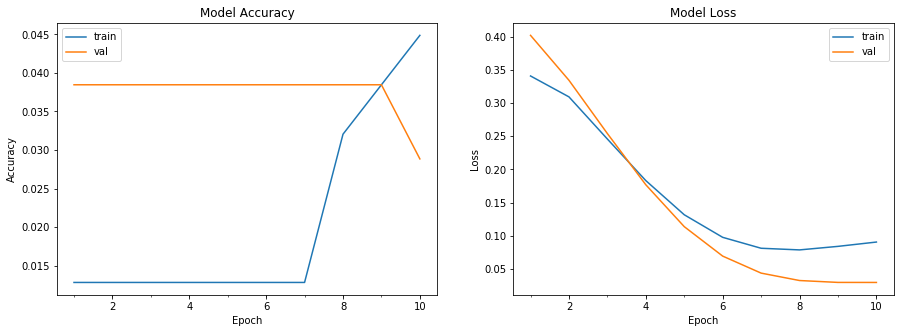

In [633]:
plot_model_history(model_info)